In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import roc_auc_score
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import re
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import pickle
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from keras.engine import Layer
from keras.layers import Activation, Add, Bidirectional, Conv1D, Dense, Dropout, Embedding, Flatten
from keras.layers import concatenate, GRU, Input, K, LSTM, MaxPooling1D
from keras.layers import GlobalAveragePooling1D,  GlobalMaxPooling1D, SpatialDropout1D
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing import text, sequence
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss
from sklearn.model_selection import train_test_split
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks


Using TensorFlow backend.


In [2]:
project_data = pd.read_csv('train_data.csv')
resource_data = pd.read_csv('resources.csv')

In [3]:
print("Number of data points in train data", project_data.shape)
print('-'*50)
print("The attributes of data :", project_data.columns.values)

Number of data points in train data (109248, 17)
--------------------------------------------------
The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


In [4]:
print("Number of data points in train data", resource_data.shape)
print(resource_data.columns.values)
resource_data.head(2)

Number of data points in train data (1541272, 4)
['id' 'description' 'quantity' 'price']


,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95


In [5]:
# We will combine these two datasets based on the id

price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
project_data = pd.merge(project_data, price_data, on='id', how='left')

In [6]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [7]:
print("printing some random essay")
print(9, project_data['essay'].values[9])
print('-'*50)
print(34, project_data['essay'].values[34])
print('-'*50)
print(147, project_data['essay'].values[147])

printing some random essay
9 Over 95% of my students are on free or reduced lunch.  I have a few who are homeless, but despite that, they come to school with an eagerness to learn.  My students are inquisitive eager learners who  embrace the challenge of not having great books and other resources  every day.  Many of them are not afforded the opportunity to engage with these big colorful pages of a book on a regular basis at home and they don't travel to the public library.  \r\nIt is my duty as a teacher to do all I can to provide each student an opportunity to succeed in every aspect of life. \r\nReading is Fundamental! My students will read these books over and over again while boosting their comprehension skills. These books will be used for read alouds, partner reading and for Independent reading. \r\nThey will engage in reading to build their \"Love for Reading\" by reading for pure enjoyment. They will be introduced to some new authors as well as some old favorites. I want my st

In [8]:
project_data = project_data.drop(["project_essay_1","project_essay_2","project_essay_3","project_essay_4","project_title"],axis=1)

In [9]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [10]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [11]:
# Combining all the above stundents 
from tqdm import tqdm
def preprocess_text(text_data):
    preprocessed_text = []
    # tqdm is for printing the status bar
    for sentance in tqdm(text_data):
        sent = decontracted(sentance)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\n', ' ')
        sent = sent.replace('\\"', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        # https://gist.github.com/sebleier/554280
        sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
        preprocessed_text.append(sent.lower().strip())
    return preprocessed_text

In [12]:
preprocessed_essay = preprocess_text(project_data['essay'].values)

100%|██████████| 109248/109248 [01:08<00:00, 1592.37it/s]


In [13]:
project_data["clean_text"] = preprocessed_essay


In [14]:
print("printing some random clean_text essay")
print(9, project_data['clean_text'].values[9])
print('-'*50)
print(34, project_data['clean_text'].values[34])
print('-'*50)
print(147, project_data['clean_text'].values[147])

printing some random clean_text essay
9 95 students free reduced lunch homeless despite come school eagerness learn students inquisitive eager learners embrace challenge not great books resources every day many not afforded opportunity engage big colorful pages book regular basis home not travel public library duty teacher provide student opportunity succeed every aspect life reading fundamental students read books boosting comprehension skills books used read alouds partner reading independent reading engage reading build love reading reading pure enjoyment introduced new authors well old favorites want students ready 21st century know pleasure holding good hard back book hand nothing like good book read students soar reading consideration generous funding contribution help build stamina prepare 3rd grade thank much reading proposal nannan
--------------------------------------------------
34 students mainly come extremely low income families majority come homes parents work full time

In [15]:
project_data = project_data.drop(['Unnamed: 0', 'id', 'teacher_id', 'project_submitted_datetime','essay'],axis=1)

In [16]:
#Categorical Features

# https://stackoverflow.com/questions/36383821/pandas-dataframe-apply-function-to-column-strings-based-on-other-column-value
project_data['project_grade_category'] = project_data['project_grade_category'].str.replace(' ','_')
project_data['project_grade_category'] = project_data['project_grade_category'].str.replace('-','_')
project_data['project_grade_category'] = project_data['project_grade_category'].str.lower()
project_data['project_grade_category'].value_counts()

grades_prek_2    44225
grades_3_5       37137
grades_6_8       16923
grades_9_12      10963
Name: project_grade_category, dtype: int64

In [17]:
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.replace(' The ','')
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.replace(' ','')
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.replace('&','_')
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.replace(',','_')
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.lower()
project_data['project_subject_categories'].value_counts()

literacy_language                       23655
math_science                            17072
literacy_language_math_science          14636
health_sports                           10177
music_arts                               5180
specialneeds                             4226
literacy_language_specialneeds           3961
appliedlearning                          3771
math_science_literacy_language           2289
appliedlearning_literacy_language        2191
history_civics                           1851
math_science_specialneeds                1840
literacy_language_music_arts             1757
math_science_music_arts                  1642
appliedlearning_specialneeds             1467
history_civics_literacy_language         1421
health_sports_specialneeds               1391
warmth_care_hunger                       1309
math_science_appliedlearning             1220
appliedlearning_math_science             1052
literacy_language_history_civics          809
health_sports_literacy_language   

In [18]:
project_data['teacher_prefix']=project_data['teacher_prefix'].fillna('Mrs.')
project_data['teacher_prefix'] = project_data['teacher_prefix'].str.replace('.','')
project_data['teacher_prefix'] = project_data['teacher_prefix'].str.lower()
project_data['teacher_prefix'].value_counts()

mrs        57272
ms         38955
mr         10648
teacher     2360
dr            13
Name: teacher_prefix, dtype: int64

In [19]:
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.replace(' The ','')
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.replace(' ','')
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.replace('&','_')
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.replace(',','_')
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.lower()
project_data['project_subject_subcategories'].value_counts()

literacy                                9486
literacy_mathematics                    8325
literature_writing_mathematics          5923
literacy_literature_writing             5571
mathematics                             5379
                                        ... 
financialliteracy_foreignlanguages         1
financialliteracy_performingarts           1
economics_other                            1
civics_government_nutritioneducation       1
esl_teamsports                             1
Name: project_subject_subcategories, Length: 401, dtype: int64

In [20]:
project_data['school_state'] = project_data['school_state'].str.lower()
project_data['school_state'].value_counts()

ca    15388
tx     7396
ny     7318
fl     6185
nc     5091
il     4350
ga     3963
sc     3936
mi     3161
pa     3109
in     2620
mo     2576
oh     2467
la     2394
ma     2389
wa     2334
ok     2276
nj     2237
az     2147
va     2045
wi     1827
al     1762
ut     1731
tn     1688
ct     1663
md     1514
nv     1367
ms     1323
ky     1304
or     1242
mn     1208
co     1111
ar     1049
id      693
ia      666
ks      634
nm      557
dc      516
hi      507
me      505
wv      503
nh      348
ak      345
de      343
ne      309
sd      300
ri      285
mt      245
nd      143
wy       98
vt       80
Name: school_state, dtype: int64

In [21]:
project_summary_numerical = []
for sentance in tqdm(project_data['project_resource_summary']):
    sent1 = decontracted(sentance)
    sent1 = ' '.join(e for e in sent1.split() if e.isdigit())
    k=len(sent1)
    project_summary_numerical.append(k)

project_data["project_summary_numerical"] = project_summary_numerical

100%|██████████| 109248/109248 [00:01<00:00, 71474.22it/s]


In [22]:
target = project_data["project_is_approved"]
features = project_data.drop(["project_resource_summary","project_is_approved"],axis=1)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, stratify=target,test_size=0.30,random_state=123)

In [23]:
# convert the sentences (strings) into integers
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words= 1000000)
tokenizer.fit_on_texts(X_train["clean_text"].tolist())
sequences_train = tokenizer.texts_to_sequences(X_train["clean_text"])
sequences_test = tokenizer.texts_to_sequences(X_test["clean_text"])

In [24]:
from keras.preprocessing.sequence import pad_sequences
word2idx = tokenizer.word_index
encoded_train = pad_sequences(sequences_train,maxlen=800,padding='post', truncating='post')
encoded_test = pad_sequences(sequences_test, maxlen=800,padding='post', truncating='post')
pickle_in = open("glove_vectors","rb")
glove_words = pickle.load(pickle_in)

In [25]:
num_words = min(1000000, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, 300))
for word, i in word2idx.items():
    if i < 1000000:
        embedding_vector = glove_words.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all zeros.
            embedding_matrix[i] = embedding_vector


print(num_words)
print("*************************************************************")
print(embedding_matrix.shape)

48930
*************************************************************
(48930, 300)


In [26]:
#Embedding layer

embedding_layer = Embedding(
  num_words,
  300,
  weights=[embedding_matrix],
  input_length=800,
  trainable=False
)
input_text = Input(shape=(800,),name="input_text")
layer = embedding_layer(input_text)
layer = LSTM(128,recurrent_dropout=0.5,kernel_regularizer=regularizers.l2(0.001),return_sequences=True)(layer) # dropout=0.5
flatten_1 = Flatten()(layer)

W0913 06:32:57.999668 140318241994496 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0913 06:32:58.020050 140318241994496 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0913 06:32:58.023037 140318241994496 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0913 06:32:58.032665 140318241994496 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0913 06:32:58.033551 1403182419

In [27]:
# Embedding layer for categorical features

no_of_unique_teacher_prefix  = X_train["teacher_prefix"].nunique()
embedding_size_teacher_prefix = int(min(np.ceil((no_of_unique_teacher_prefix)/2), 50 ))
print('Unique Categories teacher_prefix :', no_of_unique_teacher_prefix,'Embedding Size of teacher_prefix:', embedding_size_teacher_prefix)


input_teacher_prefix = Input(shape=(1,),name="teacher_prefix")
embedding_teacher_prefix = Embedding(no_of_unique_teacher_prefix, embedding_size_teacher_prefix, name="emb_teacher_prefix",trainable=True)(input_teacher_prefix)
flatten_2 = Flatten()(embedding_teacher_prefix)

lb = LabelEncoder()
encoder_teacher_prefix_train = lb.fit_transform(X_train["teacher_prefix"])
encoder_teacher_prefix_test = lb.transform(X_test["teacher_prefix"])

Unique Categories teacher_prefix : 5 Embedding Size of teacher_prefix: 3


In [28]:
# School State
no_of_unique_school_state  = X_train["school_state"].nunique()
embedding_size_school_state= int(min(np.ceil((no_of_unique_school_state)/2), 50 ))
print('Unique Categories school_state :', no_of_unique_school_state,'Embedding Size of school_state:', embedding_size_school_state)


input_school_state = Input(shape=(1,),name="school_state")
embedding_school_state = Embedding(no_of_unique_school_state,embedding_size_school_state,name="emb_school_state",trainable=True)(input_school_state)
flatten_3 = Flatten()(embedding_school_state)


encoder_school_state_train = lb.fit_transform(X_train["school_state"])
encoder_school_state_test = lb.transform(X_test["school_state"])

Unique Categories school_state : 51 Embedding Size of school_state: 26


In [29]:

no_of_unique_project_grade_category  = X_train["project_grade_category"].nunique()
embedding_size_project_grade_category = int(min(np.ceil((no_of_unique_project_grade_category)/2), 50 ))
print('Unique Categories project_grade_category:', no_of_unique_project_grade_category,'Embedding Size project_grade_category:', embedding_size_project_grade_category)




input_project_grade_category= Input(shape=(1,),name="project_grade_category")
embedding_project_grade_category = Embedding(no_of_unique_project_grade_category,embedding_size_project_grade_category,name="emb_project_grade_category",trainable=True)(input_project_grade_category)
flatten_4 = Flatten()(embedding_project_grade_category)


encoder_project_grade_category_train = lb.fit_transform(X_train["project_grade_category"])

encoder_project_grade_category_test = lb.transform(X_test["project_grade_category"])

Unique Categories project_grade_category: 4 Embedding Size project_grade_category: 2


In [30]:
# For project_subject_categories
no_of_unique_project_subject_categories  = X_train["project_subject_categories"].nunique()
embedding_size_project_subject_categories = int(min(np.ceil((no_of_unique_project_subject_categories)/2), 50 ))
print('Unique Categories project_subject_categories:', no_of_unique_project_subject_categories,'Embedding Size project_subject_categories:', embedding_size_project_subject_categories)

input_project_subject_categories= Input(shape=(1,),name="project_subject_categories")
embedding_project_subject_categories = Embedding(no_of_unique_project_subject_categories,embedding_size_project_subject_categories,name="emb_project_subject_categories",trainable=True)(input_project_subject_categories)
flatten_5 = Flatten()(embedding_project_subject_categories)


le = LabelEncoder()
le.fit(X_train["project_subject_categories"])
X_test["project_subject_categories"] = X_test["project_subject_categories"].map(lambda s: '<unknown>' if s not in le.classes_ else s)

le.classes_ = np.append(le.classes_, '<unknown>')
encoder_project_subject_categories_train = le.transform(X_train["project_subject_categories"])
encoder_project_subject_categories_test= le.transform(X_test["project_subject_categories"])


Unique Categories project_subject_categories: 51 Embedding Size project_subject_categories: 26


In [31]:
# For project_subject_subcategories
no_of_unique_subcat_1  = X_train["project_subject_subcategories"].nunique()
embedding_size_subcat_1 = int(min(np.ceil((no_of_unique_subcat_1)/2), 50 ))
print('Unique Categories:', no_of_unique_subcat_1,'Embedding Size:', embedding_size_subcat_1)

# Defining Input and Embedding Layer for the same

input_subcat_1= Input(shape=(1,),name="sub_cat_1")
embedding_subcat_1 = Embedding(no_of_unique_subcat_1,embedding_size_subcat_1,name="emb_subcat_1",trainable=True)(input_subcat_1)
flatten_6 = Flatten()(embedding_subcat_1)


le = LabelEncoder()
le.fit(X_train["project_subject_subcategories"])
X_test["project_subject_subcategories"] = X_test["project_subject_subcategories"].map(lambda s: '<unknown>' if s not in le.classes_ else s)
# X_cv["project_subject_subcategories"] = X_cv["project_subject_subcategories"].map(lambda s: '<unknown>' if s not in le.classes_ else s)
le.classes_ = np.append(le.classes_, '<unknown>')
encoder_subcat_1_train = le.transform(X_train["project_subject_subcategories"])
encoder_subcat_1_test= le.transform(X_test["project_subject_subcategories"])
# encoder_subcat_1_cv = le.transform(X_cv["project_subject_subcategories"])

Unique Categories: 391 Embedding Size: 50


In [32]:
# numerical features for our model
numerical_train_1=X_train['project_summary_numerical'].values.reshape(-1, 1)
numerical_train_2=X_train['price'].values.reshape(-1, 1)
numerical_train_3=X_train['quantity'].values.reshape(-1, 1)
numerical_train_4=X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1)

numerical_test_1=X_test['project_summary_numerical'].values.reshape(-1, 1)
numerical_test_2=X_test['price'].values.reshape(-1, 1)
numerical_test_3=X_test['quantity'].values.reshape(-1, 1)
numerical_test_4=X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1)


numerical_train=np.concatenate((numerical_train_1,numerical_train_2,numerical_train_3,numerical_train_4),axis=1)

numerical_test=np.concatenate((numerical_test_1,numerical_test_2,numerical_test_3,numerical_test_4),axis=1)

from sklearn.preprocessing import StandardScaler
normal=StandardScaler()
normal_train=normal.fit_transform(numerical_train)
normal_test=normal.transform(numerical_test)

num_features = Input(shape=(4,),name="numerical_features")
numerical_feats = Dense(100,activation="relu",kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(num_features)

In [33]:
# Building a Model-1
from keras.layers import BatchNormalization

layer_concatenate = concatenate([flatten_1,flatten_2,flatten_3,flatten_4,flatten_5,numerical_feats])
# x_concatenate = BatchNormalization()(x_concatenate)
layer = Dense(128,activation="relu", kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(layer_concatenate)
# x=LeakyReLU(alpha=0.3)(x)
layer=Dropout(0.5)(layer)
layer = Dense(256,activation="relu",kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(layer)
# x=LeakyReLU(alpha=0.3)(x)
layer=Dropout(0.5)(layer)
layer = Dense(64,activation="relu", kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(layer)
layer = BatchNormalization()(layer)
# x=LeakyReLU(alpha=0.3)(x)
output = Dense(2, activation='softmax', name='output')(layer)
Model_1 = Model(inputs=[input_text,input_teacher_prefix,input_school_state,input_project_grade_category,input_project_subject_categories,num_features],outputs=[output])
print(Model_1.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_text (InputLayer)         (None, 800)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 800, 300)     14679000    input_text[0][0]                 
__________________________________________________________________________________________________
teacher_prefix (InputLayer)     (None, 1)            0                                            
__________________________________________________________________________________________________
school_state (InputLayer)       (None, 1)            0                                            
__________________________________________________________________________________________________
project_gr

In [34]:
from sklearn.metrics import roc_auc_score

def auc1(y_true, y_pred):
    if len(np.unique(y_true[:,1])) == 1:
        return 0.5
    else:
        return roc_auc_score(y_true, y_pred)

def auroc(y_true, y_pred):
    return tf.py_func(auc1, (y_true, y_pred), tf.double)

In [35]:
train_data = [encoded_train,encoder_teacher_prefix_train,encoder_school_state_train,
              encoder_project_grade_category_train, encoder_project_subject_categories_train,normal_train]
test_data = [encoded_test,encoder_teacher_prefix_test,encoder_school_state_test,encoder_project_grade_category_test,
              encoder_project_subject_categories_test,normal_test]

from keras.utils import np_utils
Y_train = np_utils.to_categorical(y_train, 2) 
Y_test = np_utils.to_categorical(y_test, 2)

In [36]:
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
Model_1.compile(optimizer=adam, loss='categorical_crossentropy', metrics=[auroc])

W0913 06:33:00.188100 140318241994496 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0913 06:33:00.210435 140318241994496 deprecation.py:323] From <ipython-input-34-a7e6cba44e56>:10: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable,

In [37]:
history_1 = Model_1.fit(train_data,Y_train,batch_size=512, epochs=10,validation_data=(test_data,Y_test))


W0913 06:33:00.385801 140318241994496 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 76473 samples, validate on 32775 samples
Epoch 1/10
76473/76473 [==============================] - 1888s 25ms/step - loss: 1.4060 - auroc: 0.5279 - val_loss: 0.9318 - val_auroc: 0.6256
Epoch 2/10
76473/76473 [==============================] - 1958s 26ms/step - loss: 0.7991 - auroc: 0.6391 - val_loss: 0.7273 - val_auroc: 0.7016
Epoch 3/10
76473/76473 [==============================] - 1951s 26ms/step - loss: 0.6363 - auroc: 0.7134 - val_loss: 0.6148 - val_auroc: 0.7390
Epoch 4/10
76473/76473 [==============================] - 1966s 26ms/step - loss: 0.5501 - auroc: 0.7335 - val_loss: 0.5503 - val_auroc: 0.7484
Epoch 5/10
76473/76473 [==============================] - 1954s 26ms/step - loss: 0.4995 - auroc: 0.7435 - val_loss: 0.5052 - val_auroc: 0.7501
Epoch 6/10
76473/76473 [==============================] - 1958s 26ms/step - loss: 0.4681 - auroc: 0.7483 - val_loss: 0.4657 - val_auroc: 0.7492
Epoch 7/10
76473/76473 [==============================] - 1980s 26ms/step - loss: 0.44

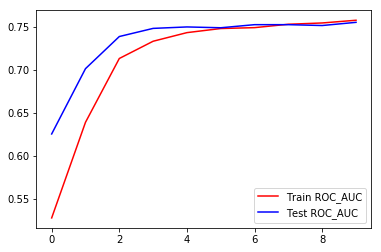

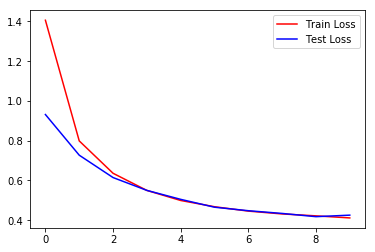

In [38]:
plt.plot(history_1.history['auroc'], 'r')
plt.plot(history_1.history['val_auroc'], 'b')
plt.legend({'Train ROC_AUC': 'r', 'Test ROC_AUC':'b'})
plt.show()


plt.plot(history_1.history['loss'], 'r')
plt.plot(history_1.history['val_loss'], 'b')
plt.legend({'Train Loss': 'r', 'Test Loss':'b'})
plt.show()

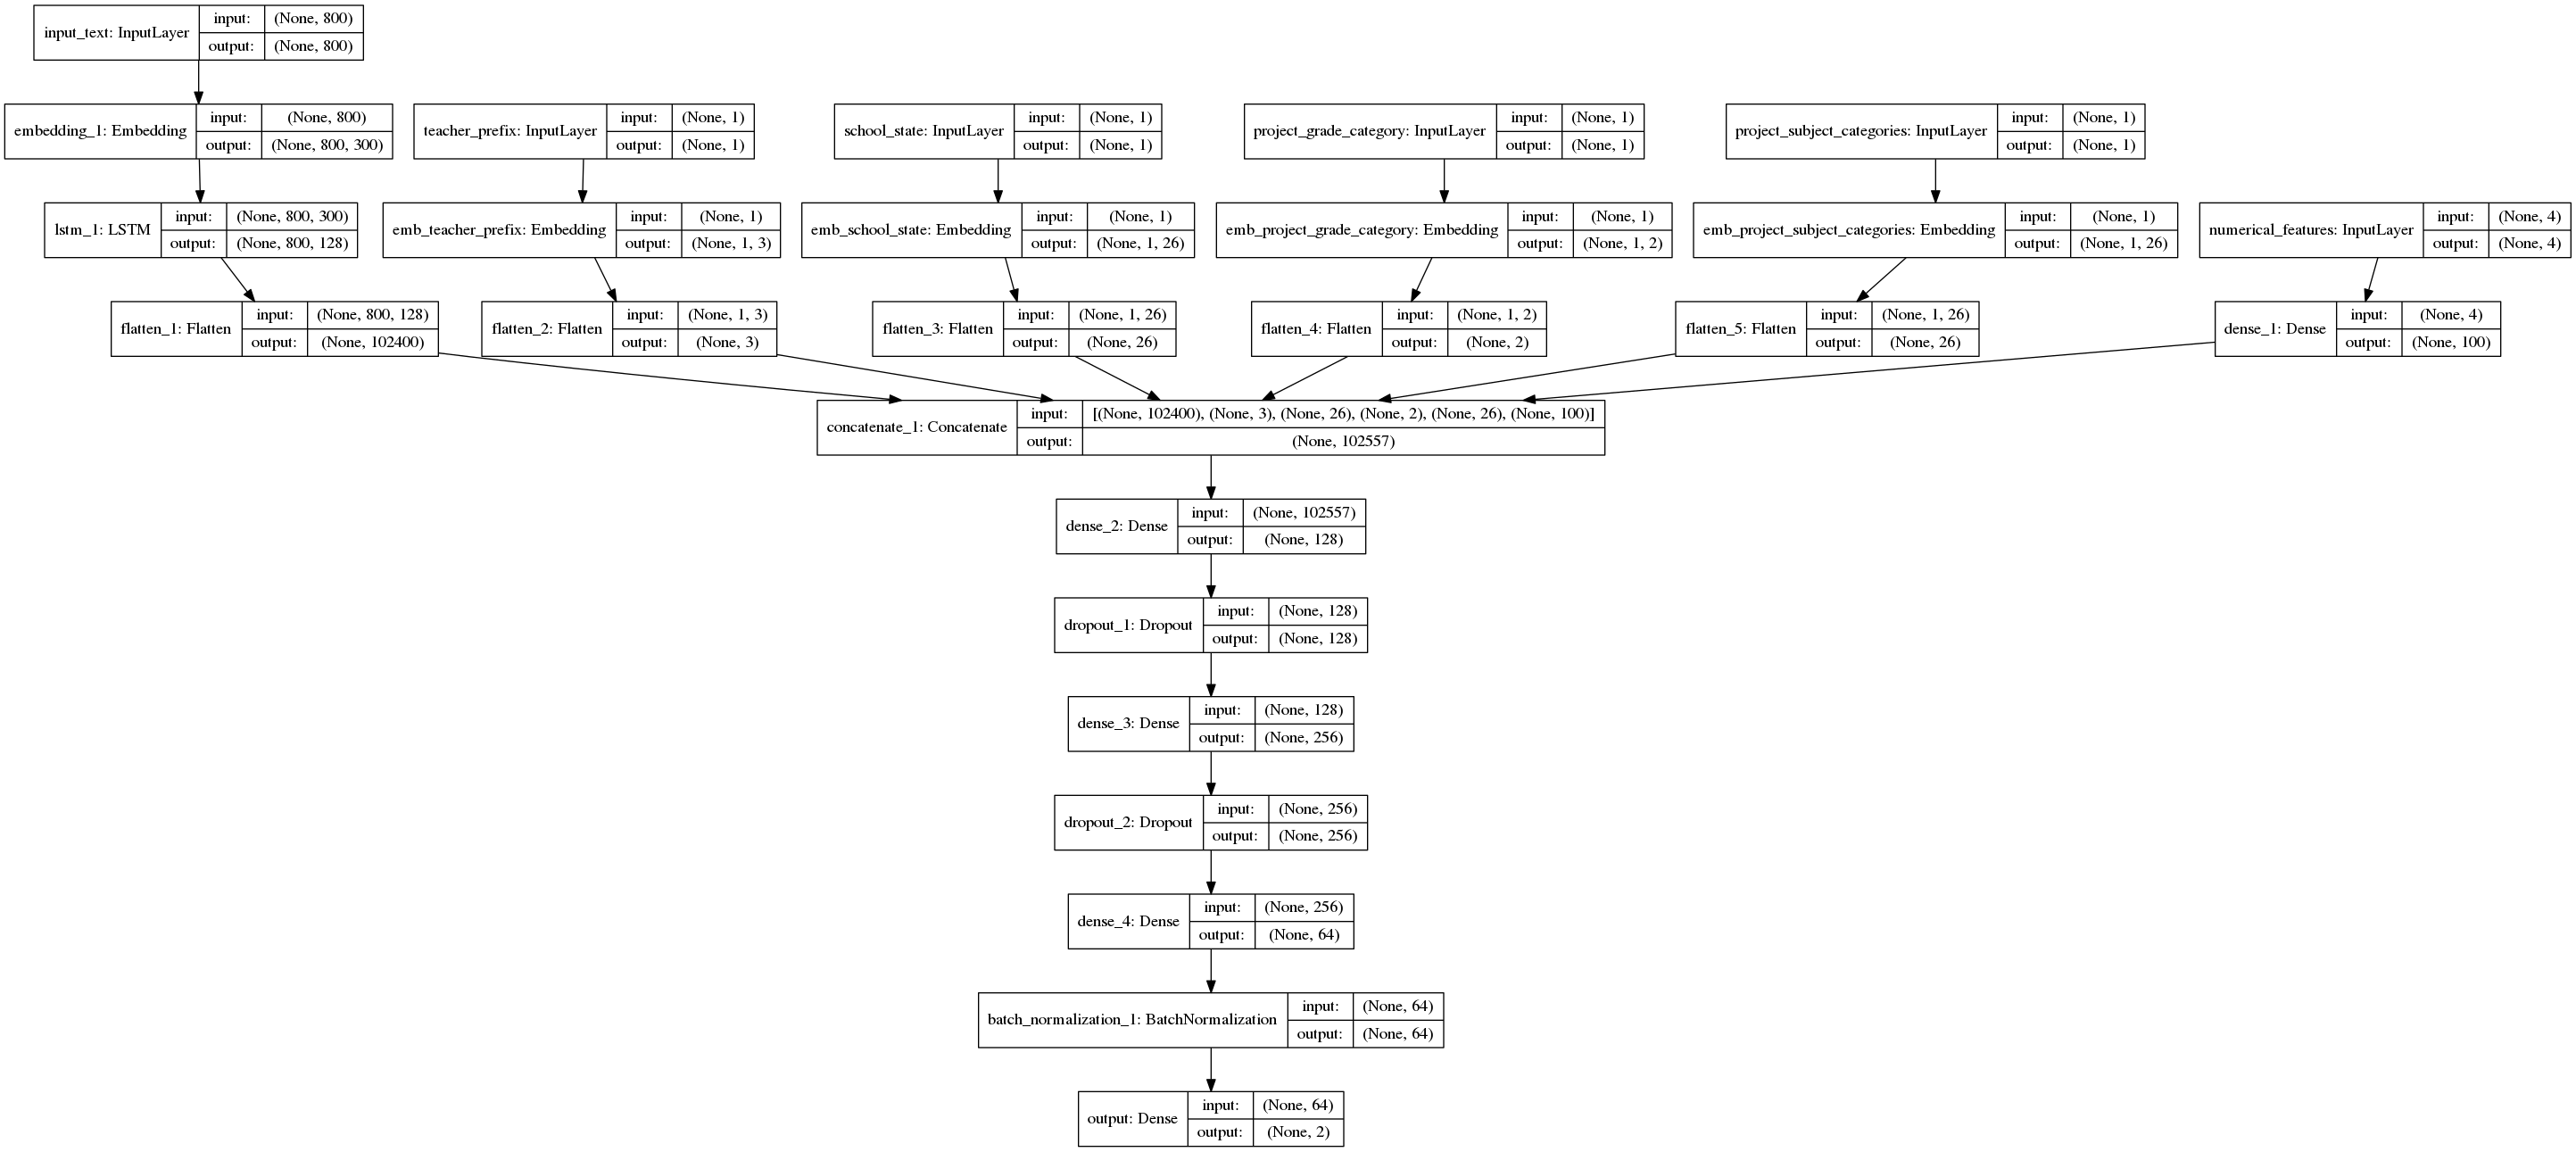

In [39]:
# https://github.com/mmortazavi/EntityEmbedding-Working_Example/blob/master/EntityEmbedding.ipynb
from keras.utils import plot_model
import pydot_ng as pydot
plot_model(Model_1, show_shapes=True, show_layer_names=True, to_file='Model_1.png')
from IPython.display import Image
Image(retina=True, filename='Model_1.png')